
Практическое задание к уроку 1 (2 неделя).
Линейная регрессия: переобучение и регуляризация

В этом задании мы на примерах увидим, как переобучаются линейные модели, разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

Во всех ячейках, где написан комментарий с инструкциями, нужно написать код, выполняющий эти инструкции. Остальные ячейки с кодом (без комментариев) нужно просто выполнить. Кроме того, в задании требуется отвечать на вопросы; ответы нужно вписывать после выделенного слова "Ответ:".

Напоминаем, что посмотреть справку любого метода или функции (узнать, какие у нее аргументы и что она делает) можно с помощью комбинации Shift+Tab. Нажатие Tab после имени объекта и точки позволяет посмотреть, какие методы и переменные есть у этого объекта.


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Мы будем работать с датасетом "bikes_rent.csv", в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.


Знакомство с данными

Загрузите датасет с помощью функции pandas.read_csv в переменную df. Выведите первые 5 строчек, чтобы убедиться в корректном считывании данных:


In [3]:
df=pd.read_csv("bikes_rent.csv")
df.head(5)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600




Для каждого дня проката известны следующие признаки (как они были указаны в источнике данных):

    season: 1 - весна, 2 - лето, 3 - осень, 4 - зима
    yr: 0 - 2011, 1 - 2012
    mnth: от 1 до 12
    holiday: 0 - нет праздника, 1 - есть праздник
    weekday: от 0 до 6
    workingday: 0 - нерабочий день, 1 - рабочий день
    weathersit: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
    temp: температура в Цельсиях
    atemp: температура по ощущениям в Цельсиях
    hum: влажность
    windspeed(mph): скорость ветра в милях в час
    windspeed(ms): скорость ветра в метрах в секунду
    cnt: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальныеми признаками тоже можно работать как с вещественными, потому что на них задан порядок. Давайте посмотрим на графиках, как целевой признак зависит от остальных


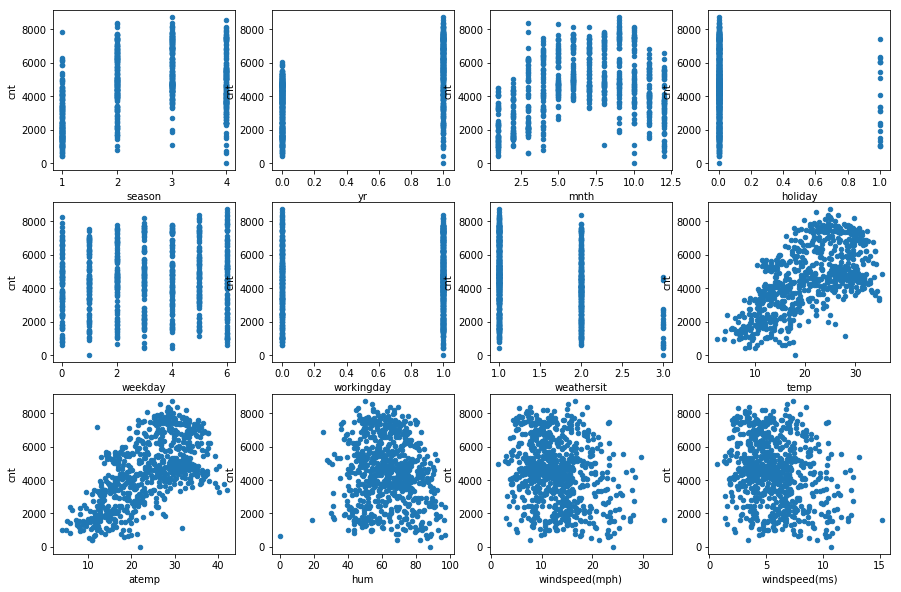

In [4]:
fig,axes=plt.subplots(nrows=3,ncols=4,figsize=(15,10))
for idx,feature in enumerate(df.columns[:-1]):
    df.plot(feature,"cnt",subplots=True,kind="scatter",ax=axes[idx/4,idx%4])


    Каков характер зависимости числа прокатов от месяца?
        ответ:
    Укажите один или два признака, от которых число прокатов скорее всего зависит линейно
        ответ:


ОТвет:Первые 5 месяцев наблюдается позитивная линейная зависимость,с 6 по 8 месяц зависимость не изменяется,с 9 по 12
    месяц можно заметиь,что звисимость меняет свое направление с позитивной на негативную. 

Ответ: temp,atemp-температура, 

Давайте более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. В pandas ее можно посчитать с помощью двух методов датафрейма: corr и corrwith. Метод df.corr вычисляет матрицу корреляций всех признаков из датафрейма. Методу df.corrwith нужно подать еще один датафрейм в качестве аргумента, и тогда он посчитает попарные корреляции между признаками из df и этого датафрейма.

In [32]:
temp_df=df[["season","yr","mnth","holiday","weekday","workingday","weathersit","temp","atemp",
            "hum","windspeed(mph)","windspeed(ms)"]]
print "Корреляция между принаками:\n{}".format(temp_df.corr())
cnt_df=df["cnt"]
print "\n"
print "Корреляция всех признаков с признаком cnt:\n{}".format(temp_df.corrwith(cnt_df))

Корреляция между принаками:
                  season        yr      mnth   holiday   weekday  workingday  \
season          1.000000 -0.001844  0.831440 -0.010537 -0.003080    0.012485   
yr             -0.001844  1.000000 -0.001792  0.007954 -0.005461   -0.002013   
mnth            0.831440 -0.001792  1.000000  0.019191  0.009509   -0.005901   
holiday        -0.010537  0.007954  0.019191  1.000000 -0.101960   -0.253023   
weekday        -0.003080 -0.005461  0.009509 -0.101960  1.000000    0.035790   
workingday      0.012485 -0.002013 -0.005901 -0.253023  0.035790    1.000000   
weathersit      0.019211 -0.048727  0.043528 -0.034627  0.031087    0.061200   
temp            0.334315  0.047604  0.220205 -0.028556 -0.000170    0.052660   
atemp           0.342876  0.046106  0.227459 -0.032507 -0.007537    0.052182   
hum             0.205445 -0.110651  0.222204 -0.015937 -0.052232    0.024327   
windspeed(mph) -0.229046 -0.011817 -0.207502  0.006292  0.014282   -0.018796   
windspeed(ms

В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

In [36]:
temp_df=df[["temp","atemp","hum","windspeed(mph)","windspeed(ms)","cnt"]]
print "Корреляция между вещественными признаками:\n{}".format(temp_df.corr())

Корреляция между вещественными признаками:
                    temp     atemp       hum  windspeed(mph)  windspeed(ms)  \
temp            1.000000  0.991702  0.126963       -0.157944      -0.157944   
atemp           0.991702  1.000000  0.139988       -0.183643      -0.183643   
hum             0.126963  0.139988  1.000000       -0.248489      -0.248489   
windspeed(mph) -0.157944 -0.183643 -0.248489        1.000000       1.000000   
windspeed(ms)  -0.157944 -0.183643 -0.248489        1.000000       1.000000   
cnt             0.627494  0.631066 -0.100659       -0.234545      -0.234545   

                     cnt  
temp            0.627494  
atemp           0.631066  
hum            -0.100659  
windspeed(mph) -0.234545  
windspeed(ms)  -0.234545  
cnt             1.000000  


На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Напоследок посмотрим средние признаков (метод mean), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

In [37]:
print "Средние значения признаков:\n{}".format(df.mean())

Средние значения признаков:
season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64


Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.


Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему.

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение. Это можно сделать с помощью метода scale.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.


In [38]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [56]:
df_shuffled=shuffle(df,random_state=123)
X=scale(df_shuffled[df_shuffled.columns[:-1]])
y=df_shuffled["cnt"]

Давайте обучим линейную регрессию на наших данных и посмотрим на веса признаков.

In [57]:
from sklearn.linear_model import LinearRegression

In [84]:
linear_regressor=LinearRegression()
linear_regressor.fit(X,y)
for name_feature,coef_feature in zip(df_shuffled.columns,linear_regressor.coef_):
    print name_feature,coef_feature

season 570.867090173
yr 1021.96635685
mnth -141.300959768
holiday -86.7554400599
weekday 137.227537942
workingday 56.393841299
weathersit -330.229722262
temp 367.481852447
atemp 585.550639889
hum -145.608750708
windspeed(mph) 1.24573031639e+13
windspeed(ms) -1.24573031641e+13




Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках.


Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

w=(XTX)−1XTy

.

Если в X есть коллинеарные (линейно-зависимые) столбцы, матрица XTX
становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация Xw≈y

. Такая ситуацию называют проблемой мультиколлинеарности, вы обсуждали ее на лекции.

С парой temp-atemp чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.


Решение проблемы мультиколлинеарности состоит в регуляризации линейной модели. К оптимизируемому функционалу прибавляют L1 или L2 норму весов, умноженную на коэффициент регуляризации α. В первом случае метод называется Lasso, а во втором --- Ridge. Подробнее об этом также рассказано в лекции.

Обучите регрессоры Ridge и Lasso с параметрами по умолчанию и убедитесь, что проблема с весами решилась.

In [85]:
from sklearn.linear_model import Lasso,Ridge

In [87]:
lasso_regressor=Lasso()
lasso_regressor.fit(X,y)
for name_feature,coef_feature in zip(df_shuffled.columns,lasso_regressor.coef_):
    print name_feature,coef_feature

season 560.241616031
yr 1019.46349407
mnth -128.730627037
holiday -86.1527813337
weekday 137.347893905
workingday 55.2123706414
weathersit -332.369856962
temp 376.36323621
atemp 576.530793505
hum -144.129155003
windspeed(mph) -197.139689402
windspeed(ms) -2.80491746151e-08


In [88]:
ridge_regressor=Ridge()
ridge_regressor.fit(X,y)
for name_feature,coef_feature in zip(df_shuffled.columns,ridge_regressor.coef_):
    print name_feature,coef_feature

season 563.064572252
yr 1018.94837879
mnth -131.873320282
holiday -86.7460979971
weekday 138.005111179
workingday 55.9031103751
weathersit -332.349788499
temp 386.457889192
atemp 566.34704706
hum -145.071327299
windspeed(mph) -99.2594410818
windspeed(ms) -99.2594411543


Блок 2. Поясните, каким образом введение регуляризации решает проблему с весами и мультиколлинеарностью.

Ответ:При введении регуляризации к оптимизруемому функционалу добавляется норма весов, умноженная на коэффициент регуляризации, таким образом налагается штраф на слишком большое увеличение весов. В результате кроме функционала ошибки минимизируются также веса коэффициенты при переменных.


Проблема вторая: неинформативные признаки

В отличие от L2-регуляризации, L1 обнуляет веса при некоторых признаках. Объяснение данному факту дается в одной из лекций курса.

Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации α
(в лекции коэффициент при регуляризаторе мог быть обозначен другой буквой).

In [109]:
alphas = np.arange(1, 500, 50)
coefs_lasso = np.zeros((alphas.shape[0], X.shape[1])) 
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1]))
for idx1,item1 in enumerate(alphas):
    lasso_r=Lasso(alpha=item1)
    lasso_r.fit(X,y)
    for idx2,item2 in enumerate(lasso_r.coef_):
        coefs_lasso[idx1][idx2]=item2
for idx1,item1 in enumerate(alphas):
    ridge_r=Ridge(alpha=item1)
    ridge_r.fit(X,y)
    for idx2,item2 in enumerate(ridge_r.coef_):
        coefs_ridge[idx1][idx2]=item2

Визуализируем динамику весов при увеличении параметра регуляризации

Text(0.5,1,u'Ridge')

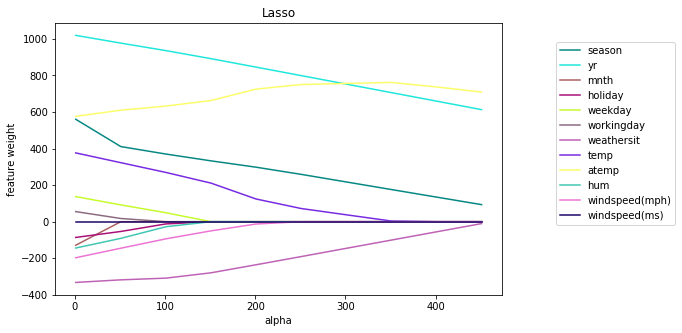

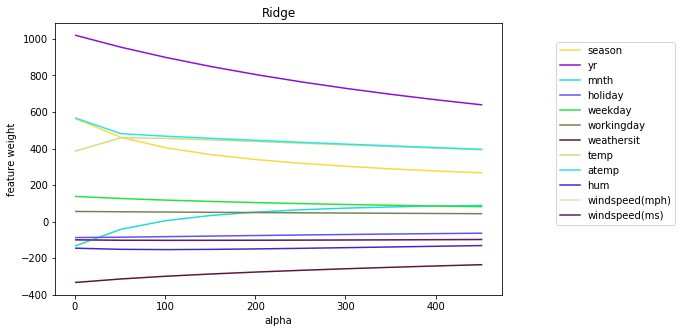

In [110]:
plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

Ответы на следующие вопросы можно давать, глядя на графики или выводя коэффициенты на печать.

Блок 3. Ответьте на вопросы (каждый 0.25 балла):

Какой регуляризатор (Ridge или Lasso) агрессивнее уменьшает веса при одном и том же alpha?

Ответ: Lasso

Что произойдет с весами Lasso, если alpha сделать очень большим? Поясните, почему так происходит.

Ответ:Если alpha сделать слишком большим,то некоторые веса становятся равными нулю потому что l1 регуляризатор не является гладким и обладает свойством,что если применять этот регуляризатор некоторые веса станут нулевыми(что решение ищется не в круглой,а ромбовидной области). 

Можно ли утверждать, что Lasso исключает один из признаков windspeed при любом значении alpha > 0? А Ridge? Ситается, что регуляризатор исключает признак, если коэффициент при нем < 1e-3.

Ответ:Да, про Lasso действительно исключает один из признаков windspeed при любом значении alpha>0,a относительно Ridge
такое утверждение не верно.

Какой из регуляризаторов подойдет для отбора неинформативных признаков?

Ответ:Lasso



Далее будем работать с Lasso.

Итак, мы видим, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее alpha.

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть Mean Square Error.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать alpha по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на K частей, или блоков, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку.

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого есть специальный регрессор, LassoCV, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную mse_path_, матрицу размера len(alpha) x k, k = 3 (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha_ будет храниться выбранное значение параметра регуляризации, а в coef_, традиционно, обученные веса, соответствующие этому alpha_.

Обратите внимание, что регрессор может менять порядок, в котором он проходит по alphas; для сопоставления с матрицей MSE лучше использовать переменную регрессора alphas_.


In [111]:
from sklearn.linear_model import LassoCV 

6
season 532.018982841
yr 1015.06022264
mnth -100.039526144
holiday -83.2939598753
weekday 132.504465491
workingday 51.5570856141
weathersit -330.55985674
temp 370.67985503
atemp 581.396931065
hum -140.007405501
windspeed(mph) -191.771408471
windspeed(ms) -2.68550245571e-08


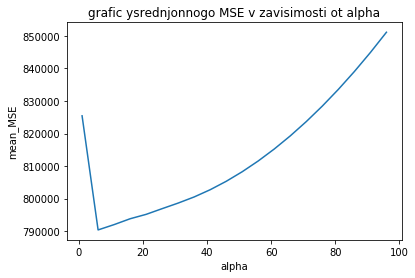

In [143]:
alphas = np.arange(1, 100, 5)
lasso_cv_reg=LassoCV(alphas=alphas)
lasso_cv_reg.fit(X,y)
mean_MSEs=[]
for ind,item in enumerate(lasso_cv_reg.alphas_):
    mean_MSE=np.mean(lasso_cv_reg.mse_path_[ind])
    mean_MSEs.append(mean_MSE)
arr_mean_MSEs=np.array(mean_MSEs)
plt.plot(lasso_cv_reg.alphas_,arr_mean_MSEs)
plt.xlabel("alpha")
plt.ylabel("mean_MSE")
plt.title("grafic ysrednjonnogo MSE v zavisimosti ot alpha")
print lasso_cv_reg.alpha_
for name_feature,coef_feature in zip(df_shuffled.columns,lasso_cv_reg.coef_):
    print name_feature,coef_feature

In [149]:
min_mse=lasso_cv_reg.mse_path_.min(axis=0)
index=np.where(lasso_cv_reg.mse_path_==min_mse)
i=0
for n in index[0]:
    i+=1
    print "alpha для минимальной MSE на {} разбиении равно {}".format(i,lasso_cv_reg.alphas_[n])

alpha для минимальной MSE на 1 разбиении равно 41
alpha для минимальной MSE на 2 разбиении равно 6
alpha для минимальной MSE на 3 разбиении равно 1


(array([ 9.,  2.,  2.,  1.,  2.,  1.,  1.,  0.,  1.,  1.]),
 array([ 843336.18149882,  845396.21433015,  847456.24716149,
         849516.27999282,  851576.31282415,  853636.34565549,
         855696.37848682,  857756.41131815,  859816.44414948,
         861876.47698082,  863936.50981215]),
 <a list of 10 Patch objects>)

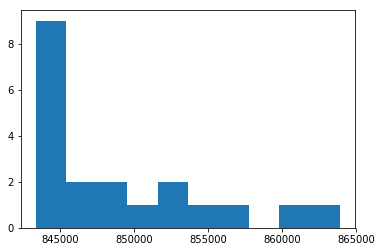

In [152]:
plt.hist(lasso_cv_reg.mse_path_[:,0])

(array([ 7.,  4.,  3.,  2.,  2.,  1.,  0.,  0.,  0.,  1.]),
 array([ 772598.49562777,  783232.34008142,  793866.18453507,
         804500.02898872,  815133.87344236,  825767.71789601,
         836401.56234966,  847035.40680331,  857669.25125696,
         868303.09571061,  878936.94016426]),
 <a list of 10 Patch objects>)

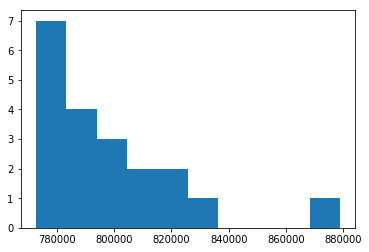

In [153]:
plt.hist(lasso_cv_reg.mse_path_[:,1])

(array([ 3.,  3.,  3.,  2.,  2.,  1.,  2.,  1.,  1.,  2.]),
 array([ 745668.6059608 ,  757401.07511662,  769133.54427244,
         780866.01342825,  792598.48258407,  804330.95173988,
         816063.4208957 ,  827795.89005152,  839528.35920733,
         851260.82836315,  862993.29751896]),
 <a list of 10 Patch objects>)

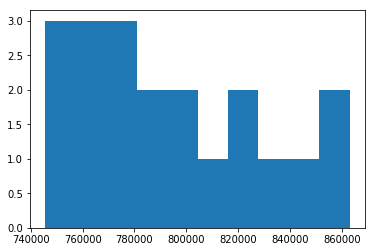

In [154]:
plt.hist(lasso_cv_reg.mse_path_[:,2])

Блок 4. Ответьте на вопросы (каждый 0.5 балла):

В последней обученной модели выберите 4 признака с наибольшими (положительными) коэфициентами (и выпишите их), посмотрите на визуализации зависимостей cnt от этих признаков, которые мы рисовали в блоке "Знакомство с данными". Видна ли возрастающая линейная зависимость cnt от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды? 

Ответ:yr,atemp,season,temp,Да для этих признаков видна возрастающая линейная зависимость cnt от них по графикам.Да данное утверждение выглядит логичным.

Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами (и выпишите их), посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?

ОТвет:weathersit,windspeed(mph),hum,Возможно ив других случаях есть такая тенденция,но ярко выражена убывающая тендеция 
вдна только на графике weathersit. Да данное утверждение звучит логично.

Выпишите признаки с коэффициентами, близкими к нулю (< 1e-3). Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?

Ответ:windspeed(ms).Данный признак был исключен из модели потому что он полностью повторяет признак windspeed(mph)только в других единицах измерения.Нет он влияет на спро на велосипедыБно точн также как и windspeed(mph)
поэтому его можно исключить.